In [2]:
import parselmouth
import matplotlib.pyplot as plt
import numpy as np
import glob
import os.path
import pandas as pd

In [3]:
# the differnt emotions in the fiels
emotions = ['anxiety', 'boredom', 'cold-anger', 'contempt', 'despair', 'disgust', 'elation', 'happy',
            'hot-anger', 'interest', 'neutral', 'panic',    'pride',    'sadness', 'shame']
clr =      ["red",  "cyan",   "orange",  "purple",   "magenta", "green",    "yellow",  "pink",
            "yellow", "green", "magenta", "purple",  "orange", "cyan",      "red"]

speakers = ['mf_001', 'cc_001', 'jg_001', 'mm_001', 'cl_001', 'gg_001', 'mk_001']

In [ ]:
# array that keeps all the features
features = []
# stroing the neutral features by speaker
neutralFeat = {}

# batching processing the audio file
# all the files should be contained in the folder called speech_files
for wave_file in glob.glob("./speech_files/*.wav"):
    
    sp = wave_file.split("/")[-1].split("_")
    spkr = sp[0]+"_"+sp[1]
    emot = sp[2]
    cont = sp[-1][:len(sp[-1])-4]
    
#     print( spkr, emot, cont)
    
    # getting the file and getting the left channel
    print("Processing {}...".format(wave_file))
    snd = parselmouth.Sound(wave_file)
    snd = snd.extract_left_channel()

    # getting pitch features
    # using autocorelation with a range of 75- 600 as specified in the assignemnt
    pitch = snd.to_pitch_ac(pitch_floor=75, pitch_ceiling=600)
    pitch_values = pitch.selected_array['frequency']
    
    # disregarding the zero values (will introduce noise such as in whispers but Zixiaofan Yang said it is noise)
    pitch_values_nonzeroes = pitch_values[np.nonzero(pitch_values)]
    
    minPitch = np.min(pitch_values_nonzeroes)
    maxPitch = np.max(pitch_values_nonzeroes)
    avgPitch = np.mean(pitch_values_nonzeroes)
    
#     print(pitch_values)
#     print(len(pitch_values_nonzeroes), len(pitch_values))
#     print(minPitch, maxPitch, avgPitch)
#     print(np.min(pitch_values), np.max(pitch_values), np.mean(pitch_values))
#     print(minPitch-np.min(pitch_values), maxPitch-np.max(pitch_values), avgPitch-np.mean(pitch_values))
#     print("***************************")


    # getting intensity features    
    intensity = snd.to_intensity()

    minIntensity = intensity.get_minimum()
    maxIntensity = intensity.get_maximum()
    avgIntensity = intensity.get_average()
    
#     print(minIntensity, maxIntensity, avgIntensity)
    
    # storing the features
    features.append([spkr, emot, cont, minPitch, maxPitch, avgPitch, minIntensity, maxIntensity, avgIntensity])

    
    # stroign the neutral features by speaker
    if emot == "neutral":
        if spkr in neutralFeat:
            neutralFeat[spkr][0].append(minPitch)
            neutralFeat[spkr][1].append(maxPitch)
            neutralFeat[spkr][2].append(avgPitch)
            neutralFeat[spkr][3].append(minIntensity)
            neutralFeat[spkr][4].append(maxIntensity)
            neutralFeat[spkr][5].append(avgIntensity)
            
        else:
            # stored in the same format of list
            neutralFeat[spkr] = [[minPitch],[maxPitch],[avgPitch],[minIntensity],[maxIntensity],[avgIntensity]]
        

In [5]:
print(neutralFeat.keys())

dict_keys(['mf_001', 'cc_001', 'jg_001', 'mm_001', 'cl_001', 'gg_001', 'mk_001'])


In [6]:
# getting the average of the neutral features
avgN = {}
for val in neutralFeat:
    pmin = np.mean((neutralFeat[val][0]))
    pmax = np.mean((neutralFeat[val][1]))    
    pavg = np.mean((neutralFeat[val][2]))
    imin = np.mean((neutralFeat[val][3]))        
    imax = np.mean((neutralFeat[val][4]))
    iavg = np.mean((neutralFeat[val][5]))    
    avgN[val] = [pmin, pmax, pavg, imin, imax, iavg]
    
print(avgN)

{'mf_001': [101.78921866348064, 129.60062761796104, 110.06143096316055, 19.447034952077864, 66.57543461602557, 59.16038868222504], 'cc_001': [83.76354603838894, 195.72648581406477, 102.809033944236, 34.24939828475776, 75.14631346205539, 68.52939872230765], 'jg_001': [133.46719848794538, 366.6588161419602, 210.05423388279542, 29.47689238644918, 72.92033456984097, 62.984659648821435], 'mm_001': [122.65865682486589, 295.1941189723659, 179.61474018297739, 40.9733168881269, 78.59470148556589, 71.64678040951077], 'cl_001': [78.53669760205561, 106.93181250385531, 85.96628901166768, 16.750118464522863, 67.80626032062774, 58.73583973772404], 'gg_001': [105.36361834940966, 302.07355739941397, 167.4742289109996, 23.725023182724172, 75.42762391138993, 68.13253301278304], 'mk_001': [172.34726446849356, 274.84841512338994, 218.02767831931004, 22.225440726087502, 66.96109335995537, 58.82757512754303]}


In [7]:
# normalizing features

normal_features = []

for file in features:
    norms = avgN[file[0]]
    
    normal_features.append([file[0], file[1], file[2], file[3]-norms[0], file[4]-norms[1], file[5]-norms[2]
                            , file[6]-norms[3], file[7]-norms[4], file[8]-norms[5]])


In [8]:
# creating the dataframe

feat = pd.DataFrame(features, columns=['speaker', 'emotion', 'content', 'minimum_pitch', 'maximum_pitch', 'average_pitch', 'minimum_intensity' , 'maximum_intensity', 'average_intensity'])

normFeat = pd.DataFrame(normal_features, columns=['speaker', 'emotion', 'content', 'minimum_pitch', 'maximum_pitch', 'average_pitch', 'minimum_intensity' , 'maximum_intensity', 'average_intensity'])



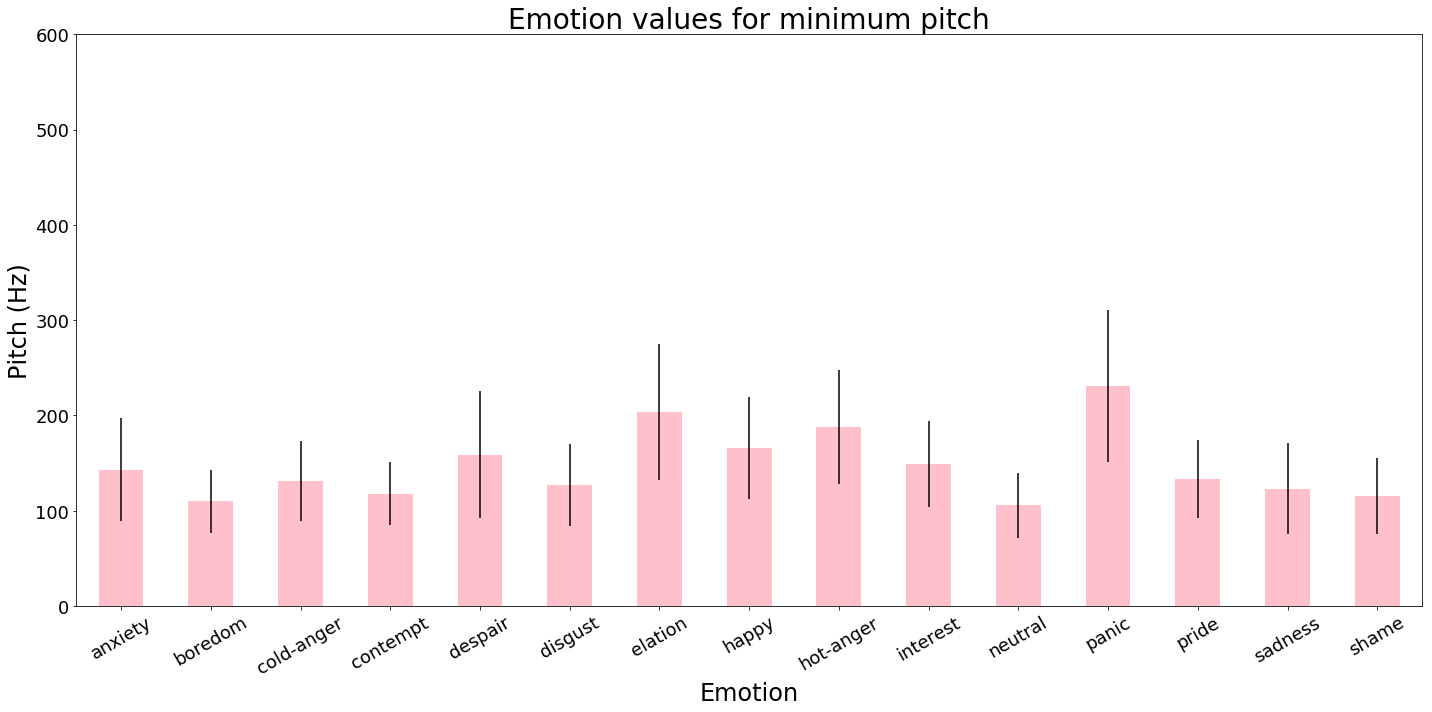

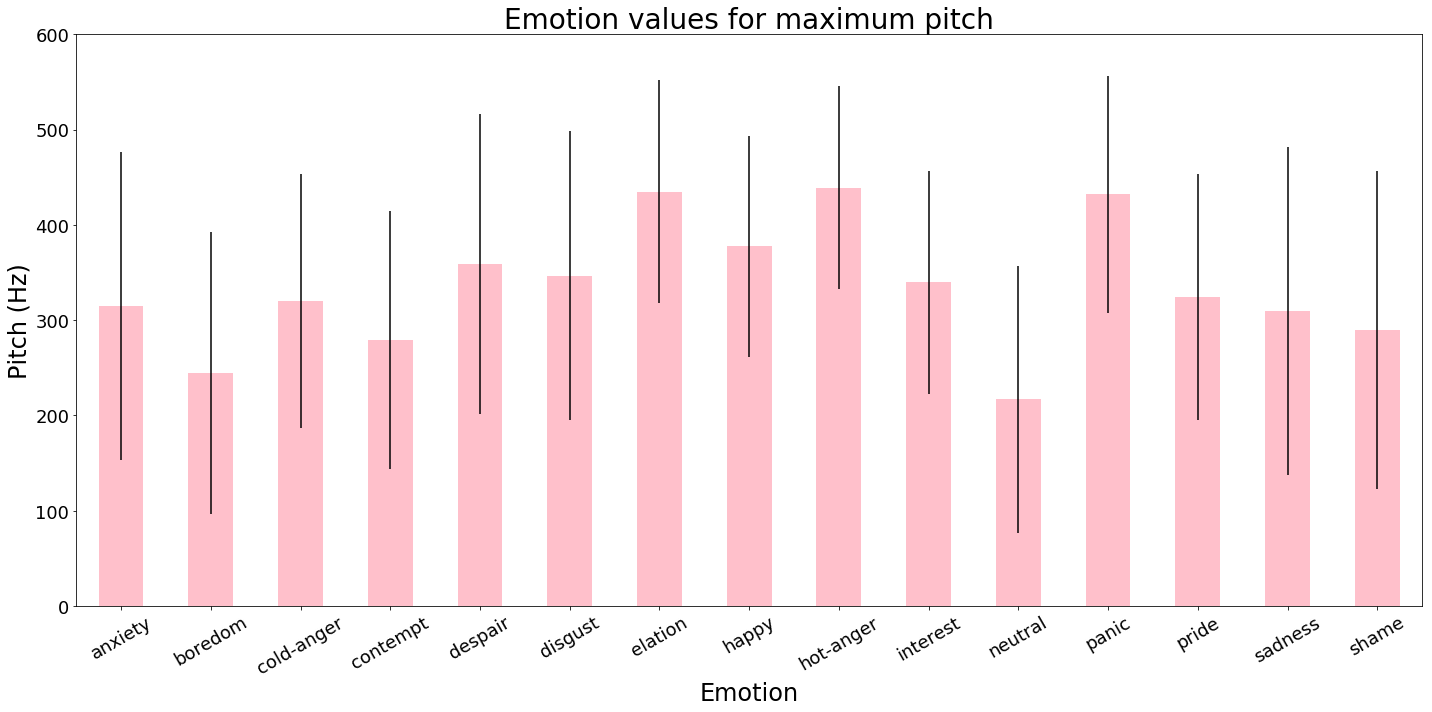

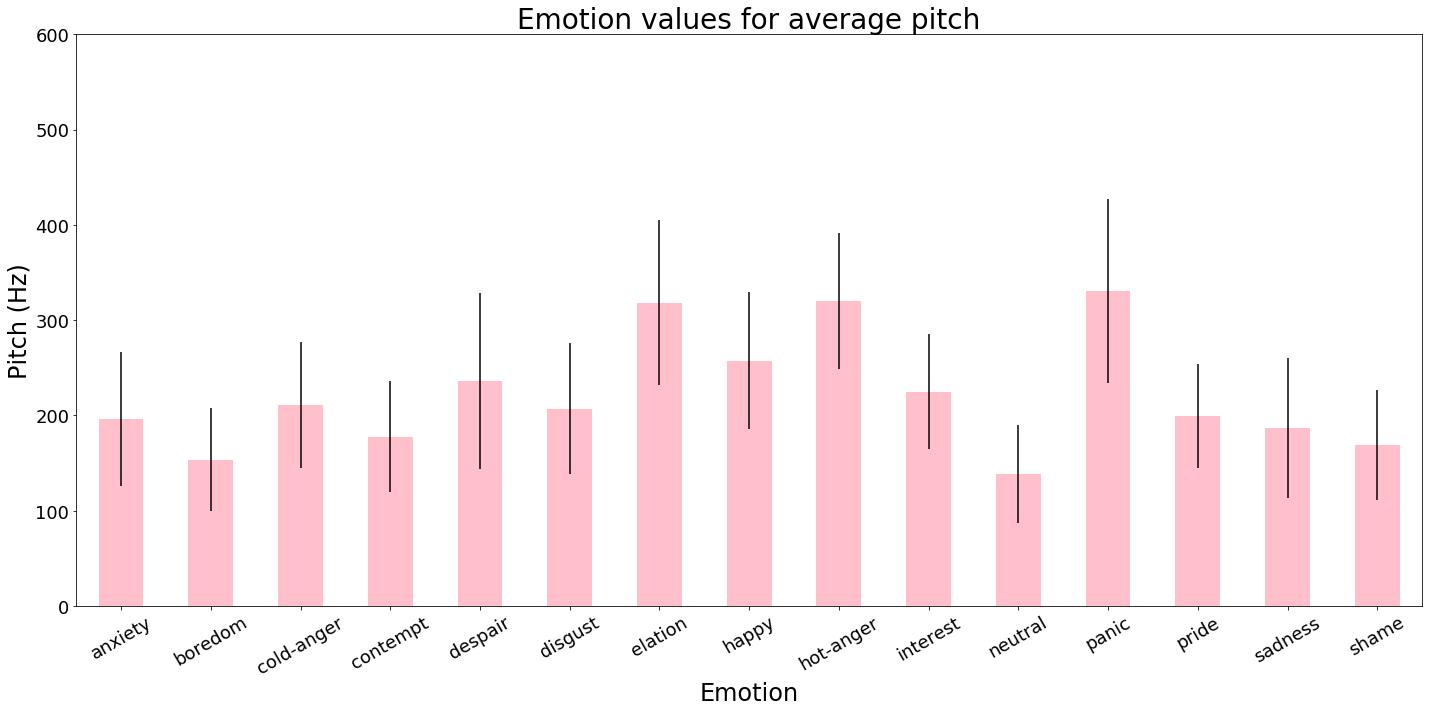

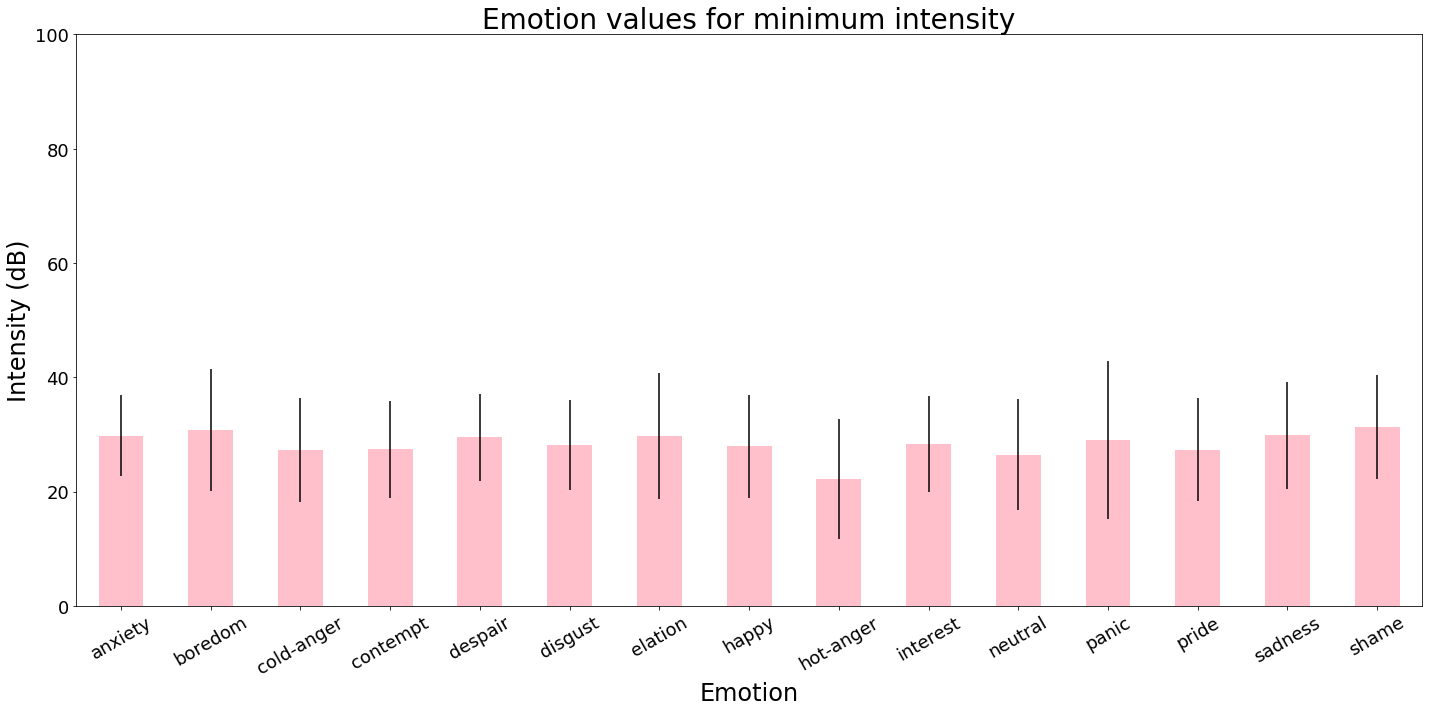

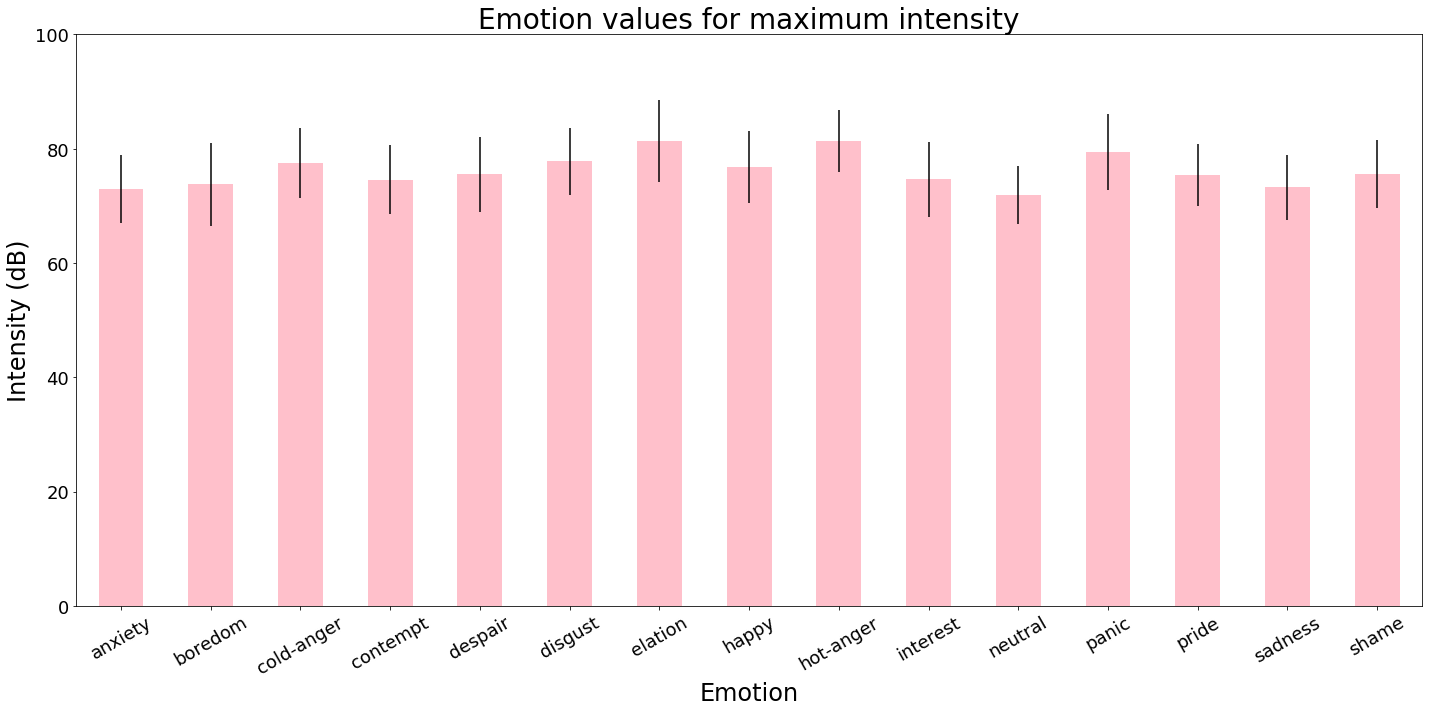

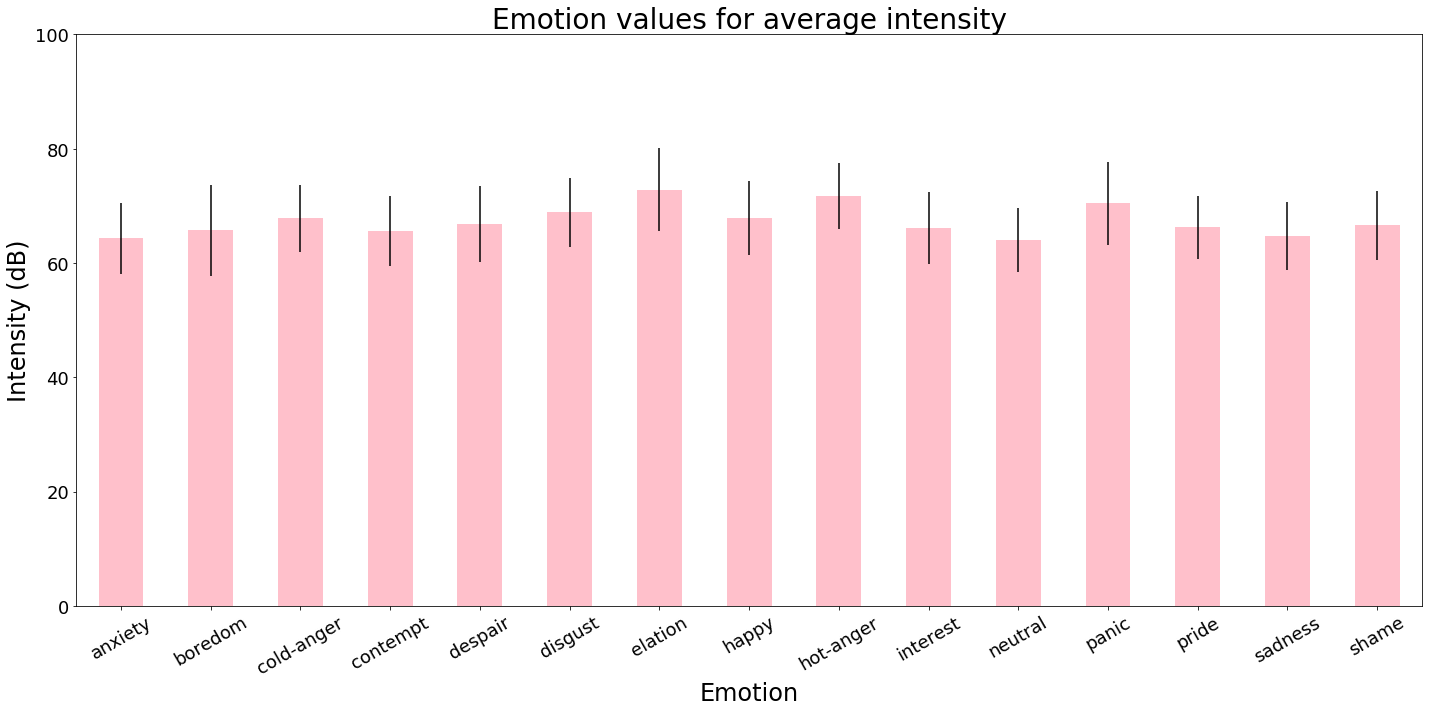

In [9]:
# plotting the mean and the standard deviation

mean = feat.groupby("emotion").mean()
std = feat.groupby("emotion").std()

cname = list(mean.columns)
for x in range(6):
    f = cname[x]
    plt.figure()
    plot = mean[f].plot(figsize=(20,10) , kind="bar", rot=30,
                        color='pink',
                        fontsize=18 ,yerr=std[f])
    
    
    # title
    plot.set_title("Emotion values for "+ f.split('_')[0] + ' ' + f.split('_')[1], fontsize= 28)
    # x label
    plot.set_xlabel("Emotion", fontsize=24)
    # y label
    if x < 3:
        plot.set_ylabel("Pitch (Hz)", fontsize=24)
        plot.set_ylim(0,600)
    else:
        plot.set_ylabel("Intensity (dB)", fontsize=24)
        plot.set_ylim(0,100)
        
    # save the figure
    plt.tight_layout()
    plt.savefig('./Images/' + f + ".jpg")
#     break

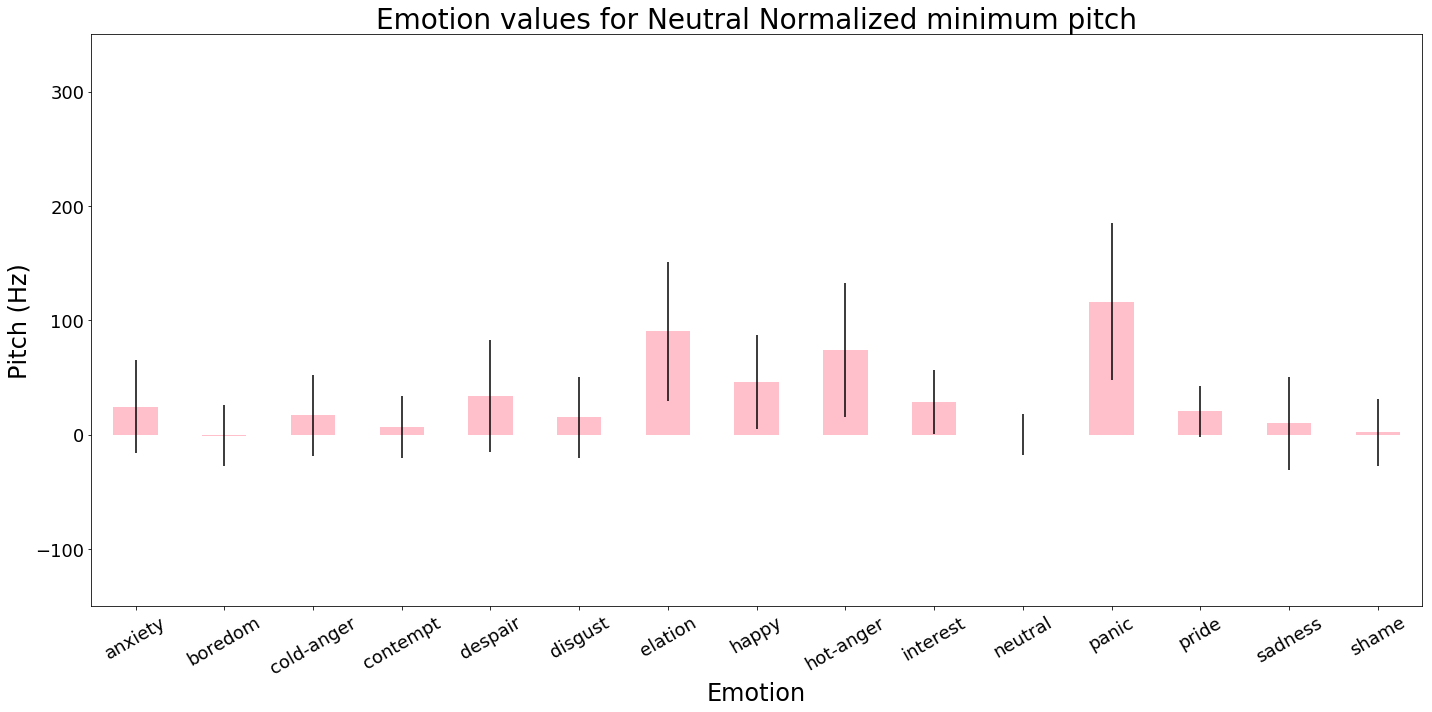

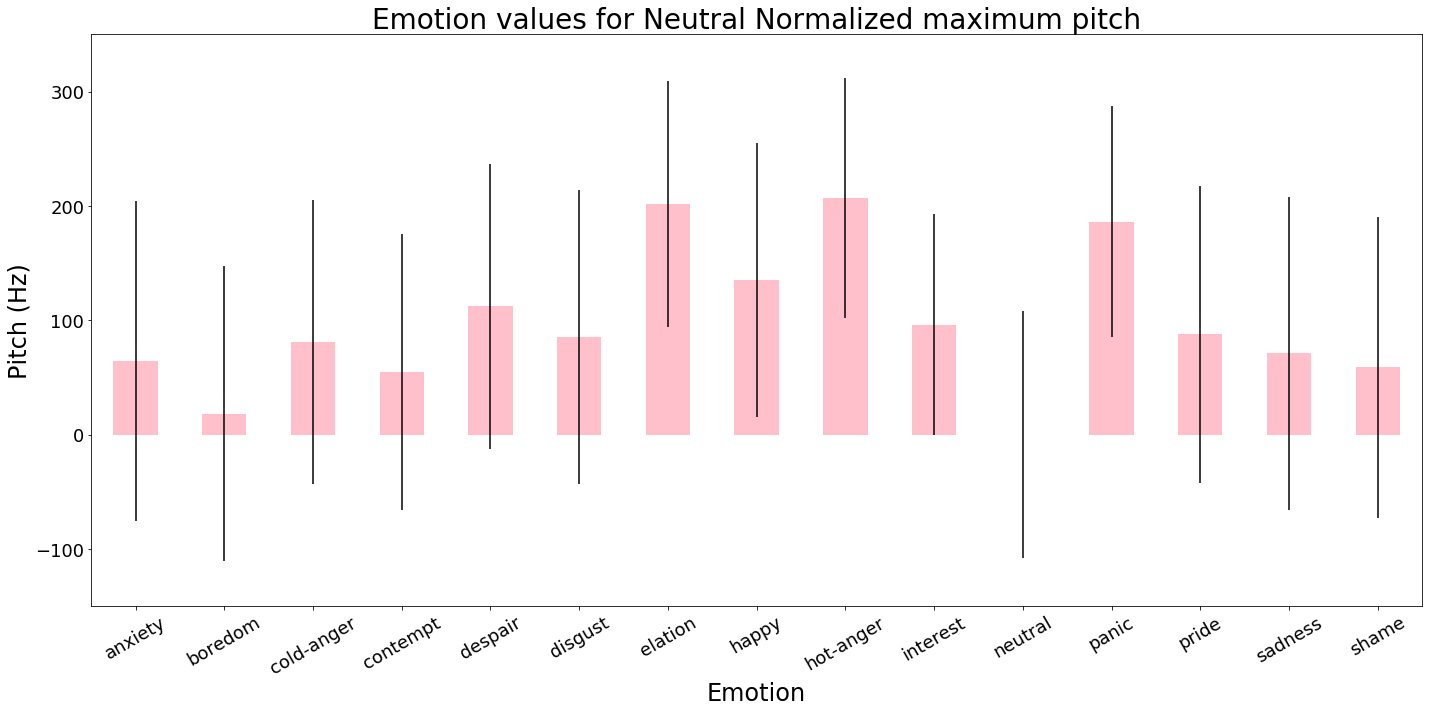

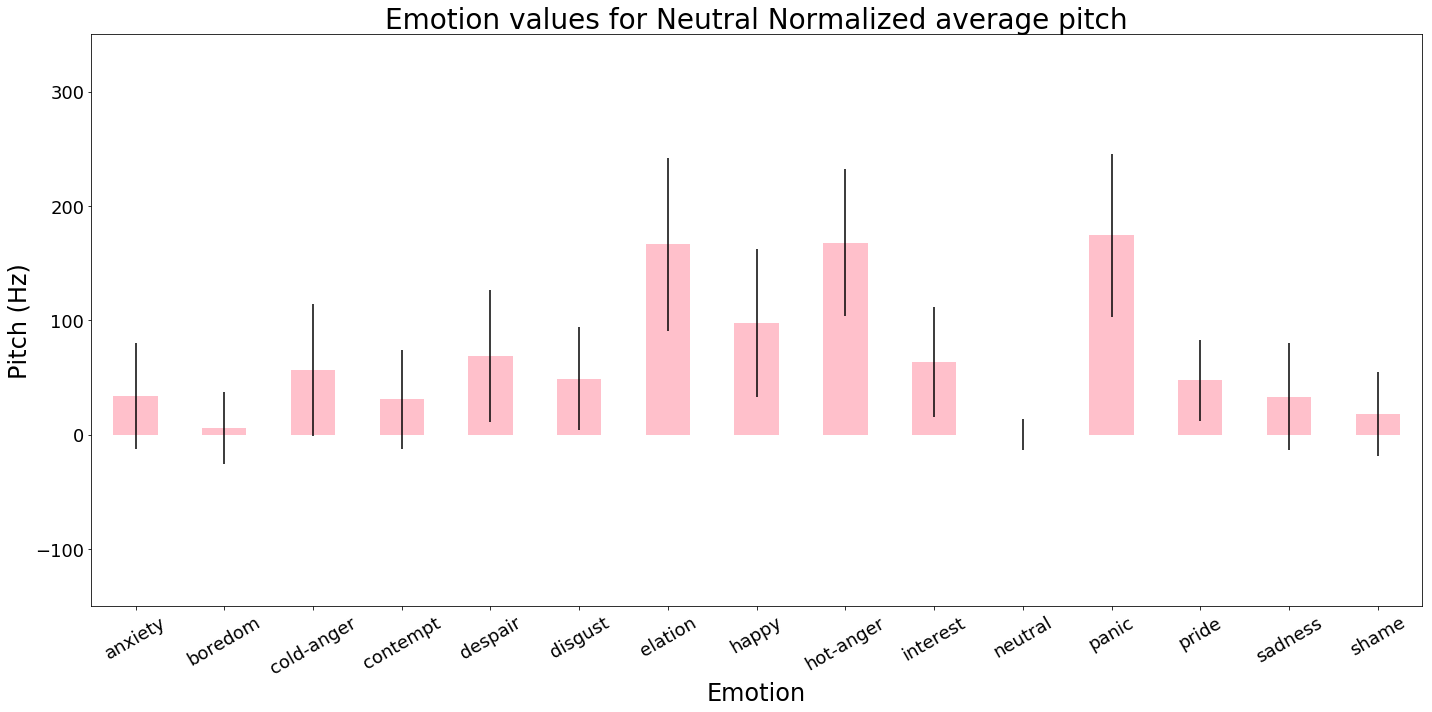

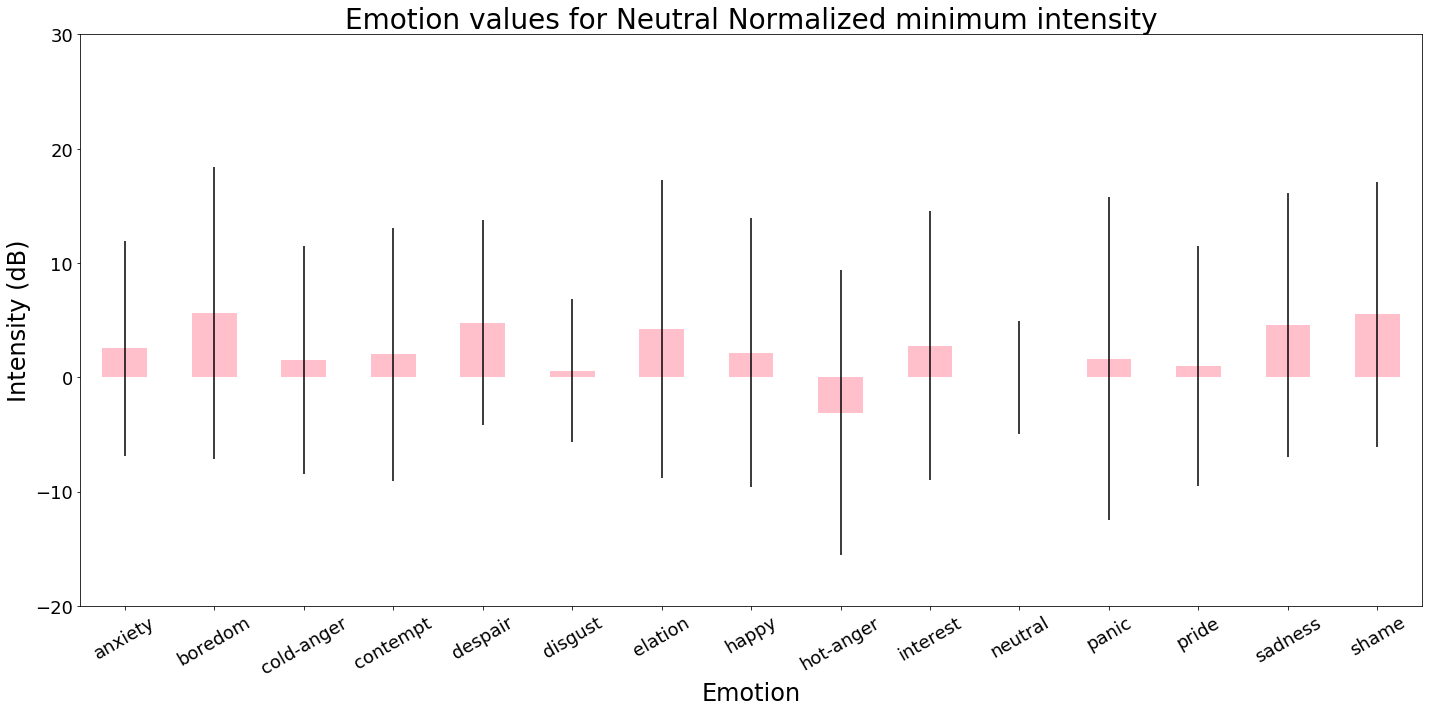

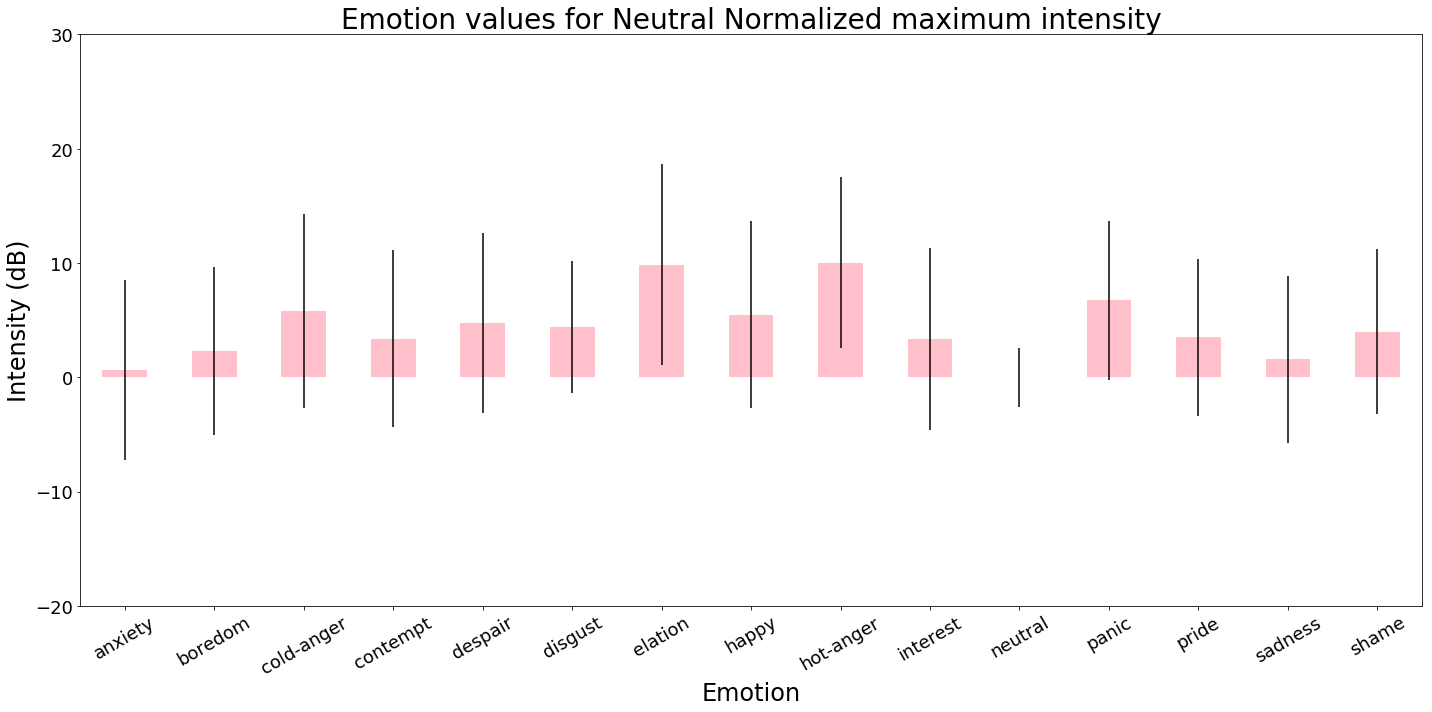

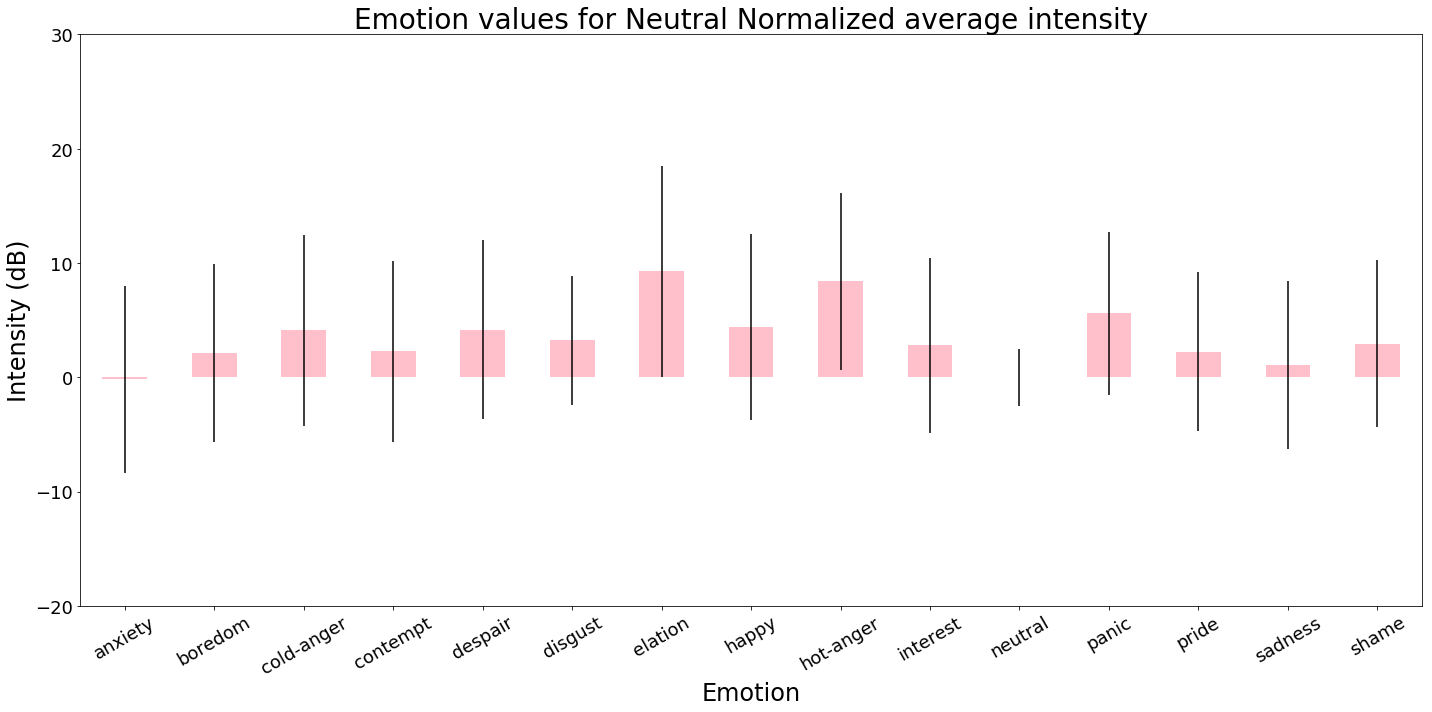

In [10]:
# plotting the mean and the standard deviation

nmean = normFeat.groupby("emotion").mean()
nstd = normFeat.groupby("emotion").std()
# print(nmean)
# print(mean)
# assert 1==2
cname = list(mean.columns)
for x in range(6):
    f = cname[x]
    plt.figure()
    plot = nmean[f].plot(figsize=(20,10) , kind="bar", rot=30,
                        color='pink',
                        fontsize=18 ,yerr=nstd[f])
    
    
    # title
    plot.set_title("Emotion values for Neutral Normalized "+ f.split('_')[0] + ' ' + f.split('_')[1], fontsize= 28)
    # x label
    plot.set_xlabel("Emotion", fontsize=24)
    # y label
    if x < 3:
        plot.set_ylabel("Pitch (Hz)", fontsize=24)
        plot.set_ylim(-150,350)
    else:
        plot.set_ylabel("Intensity (dB)", fontsize=24)
        plot.set_ylim(-20,30)
        
    # save the figure
    plt.tight_layout()
    plt.savefig('./Images/' + "NeutralNormalised_" + f + ".jpg")
#     break


['minimum_pitch', 'maximum_pitch', 'average_pitch', 'minimum_intensity', 'maximum_intensity', 'average_intensity']


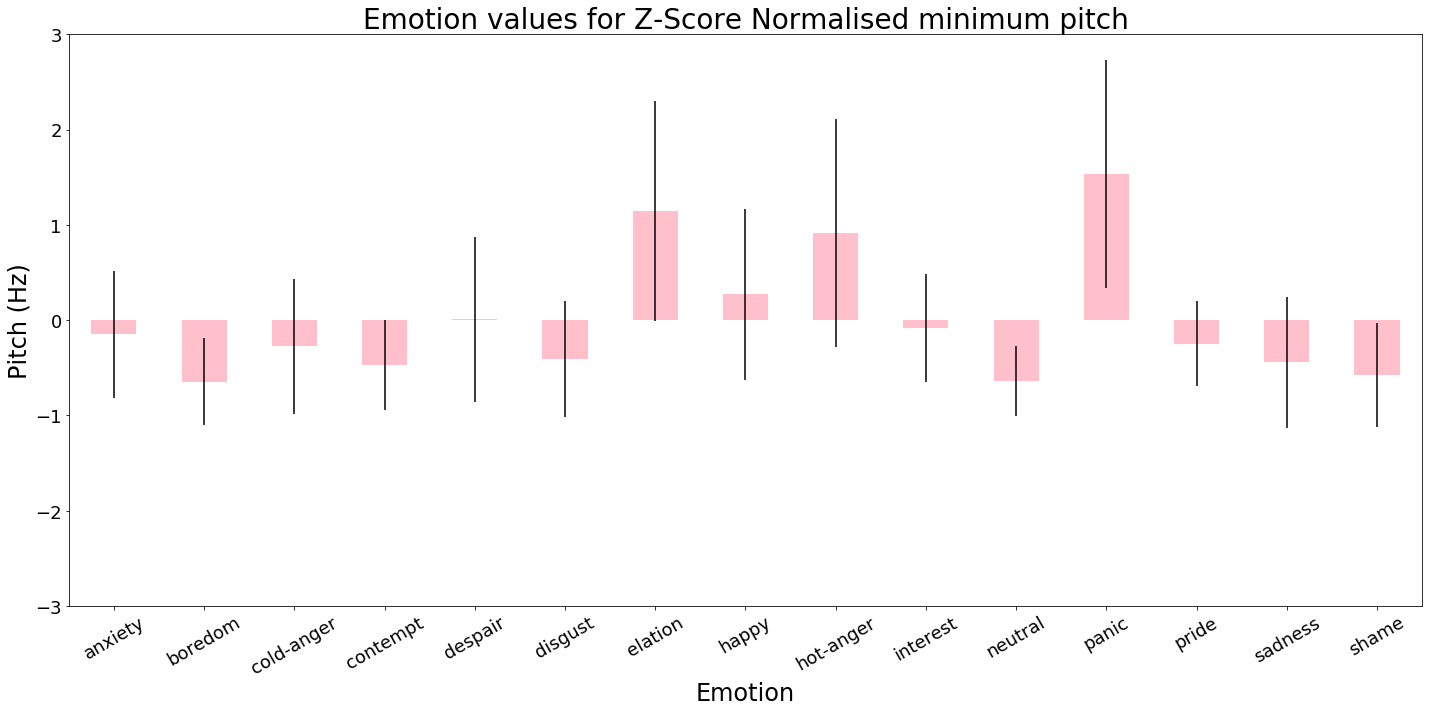

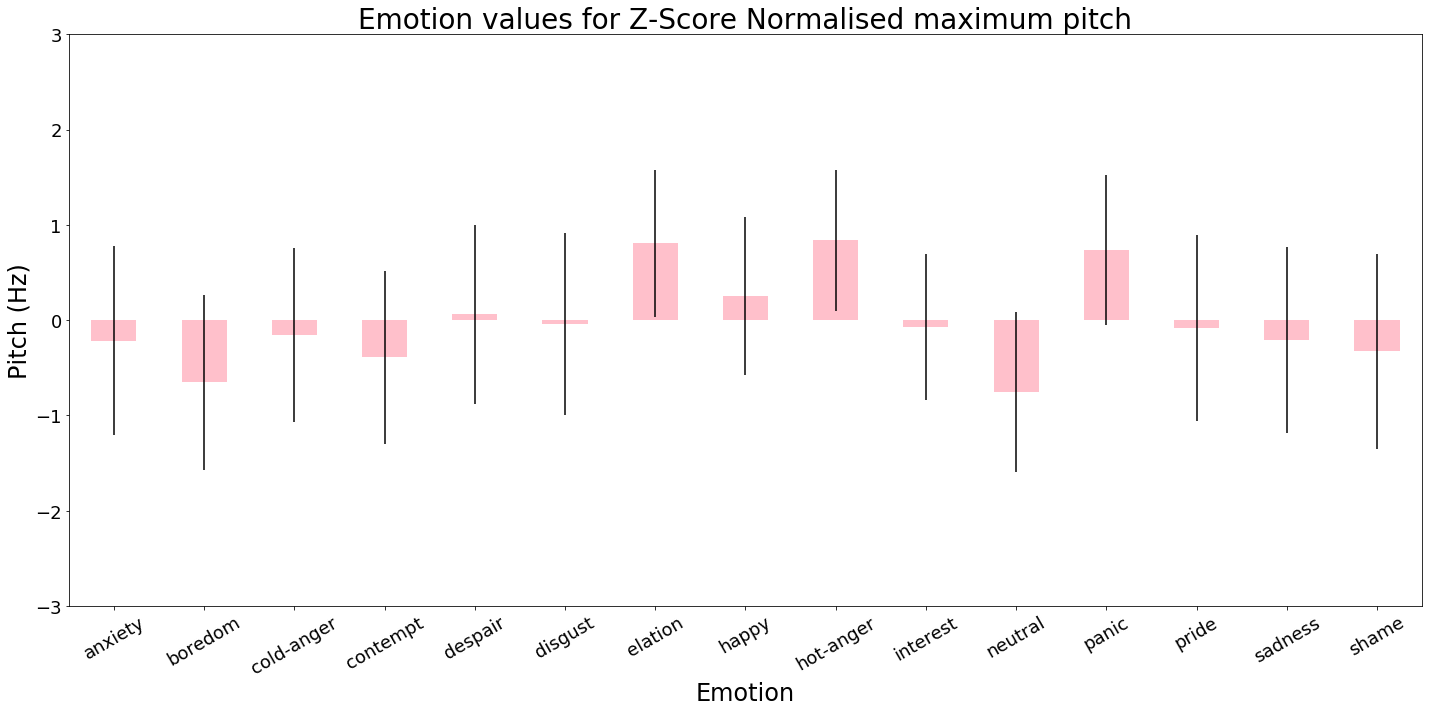

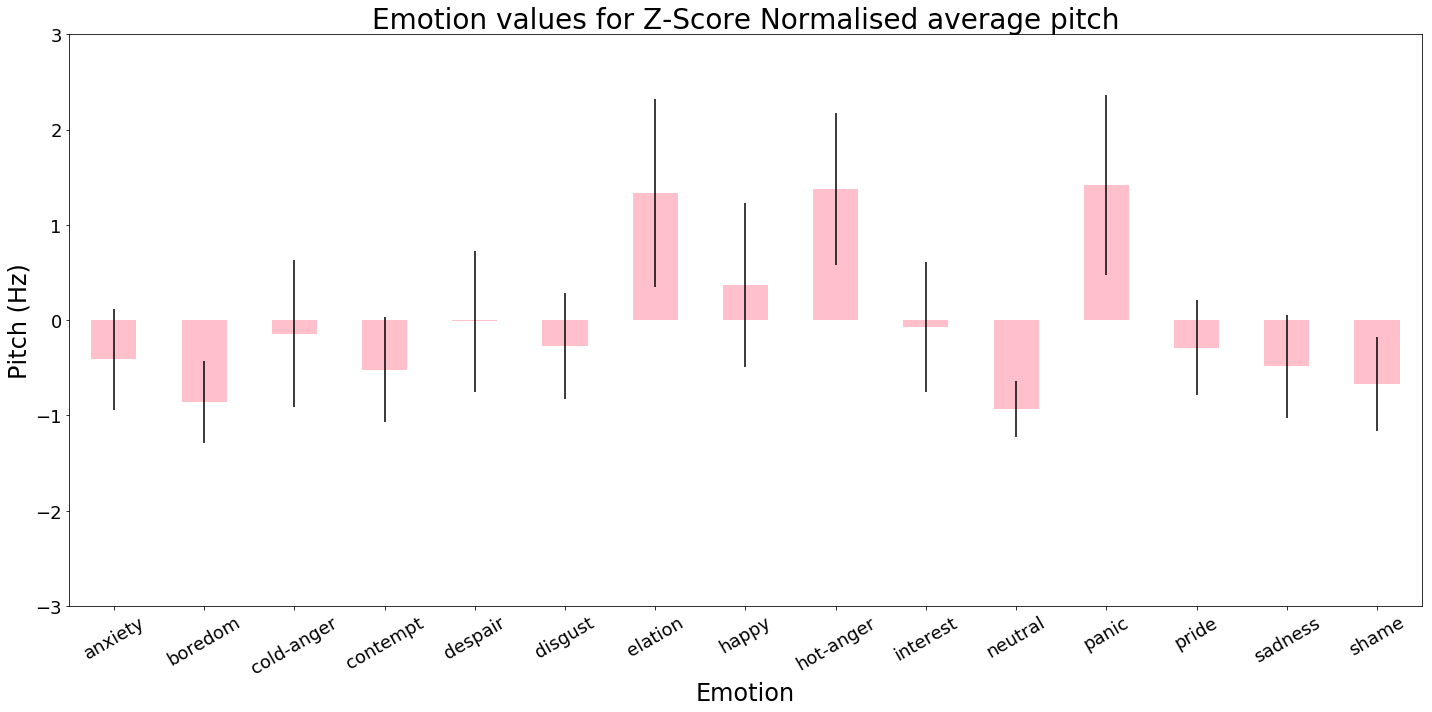

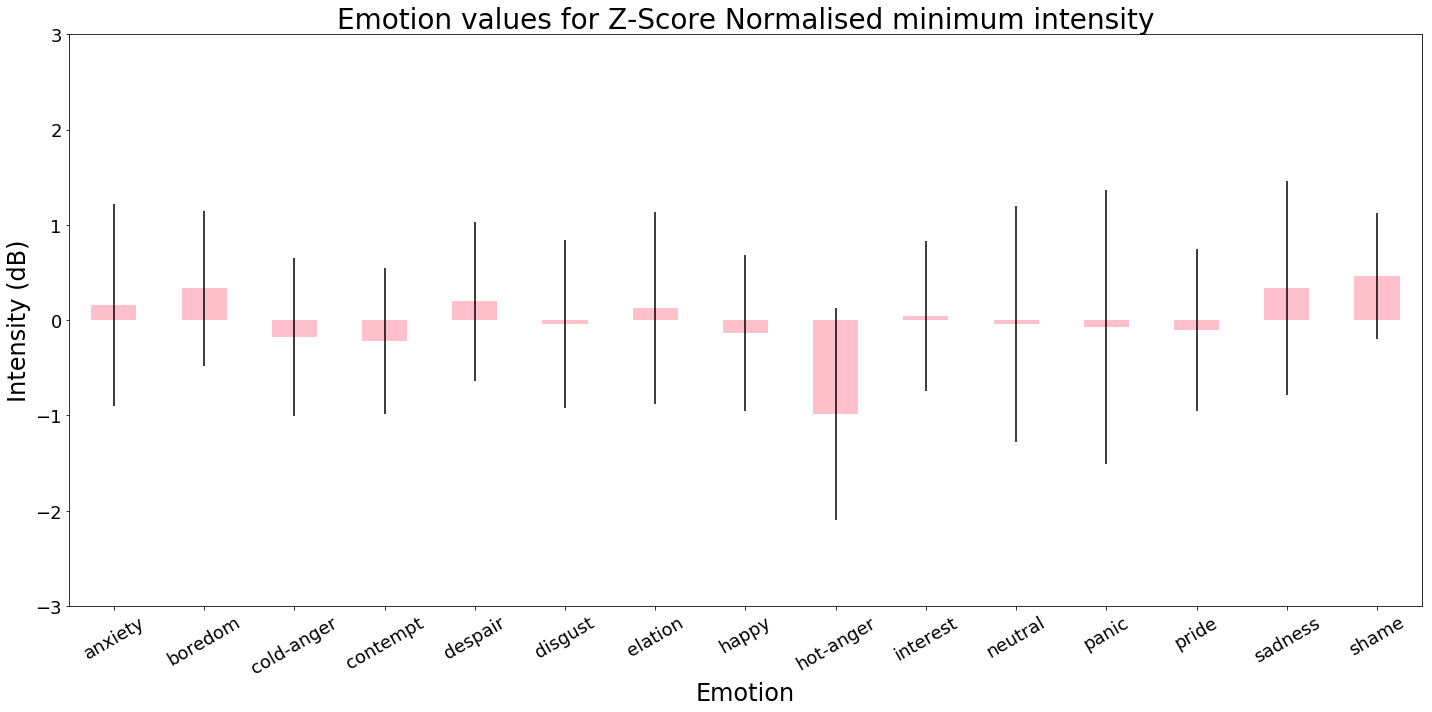

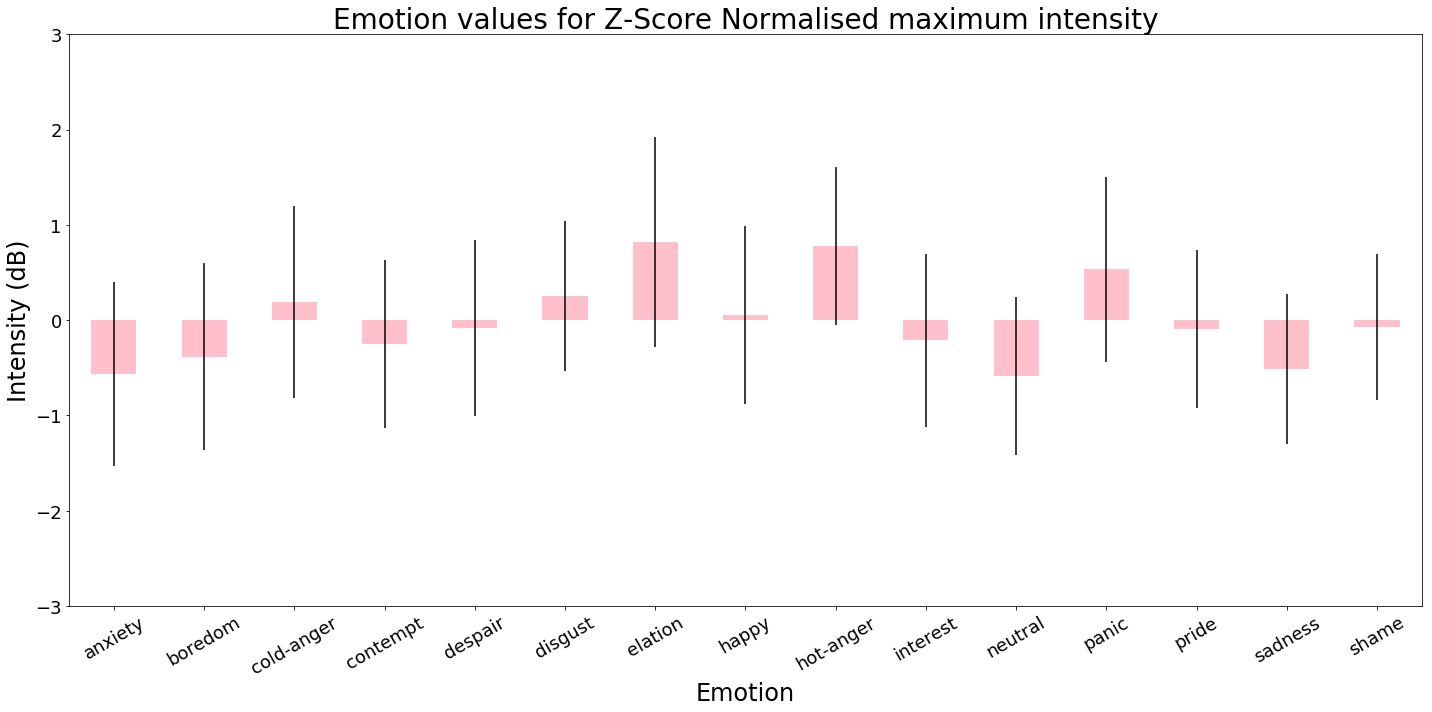

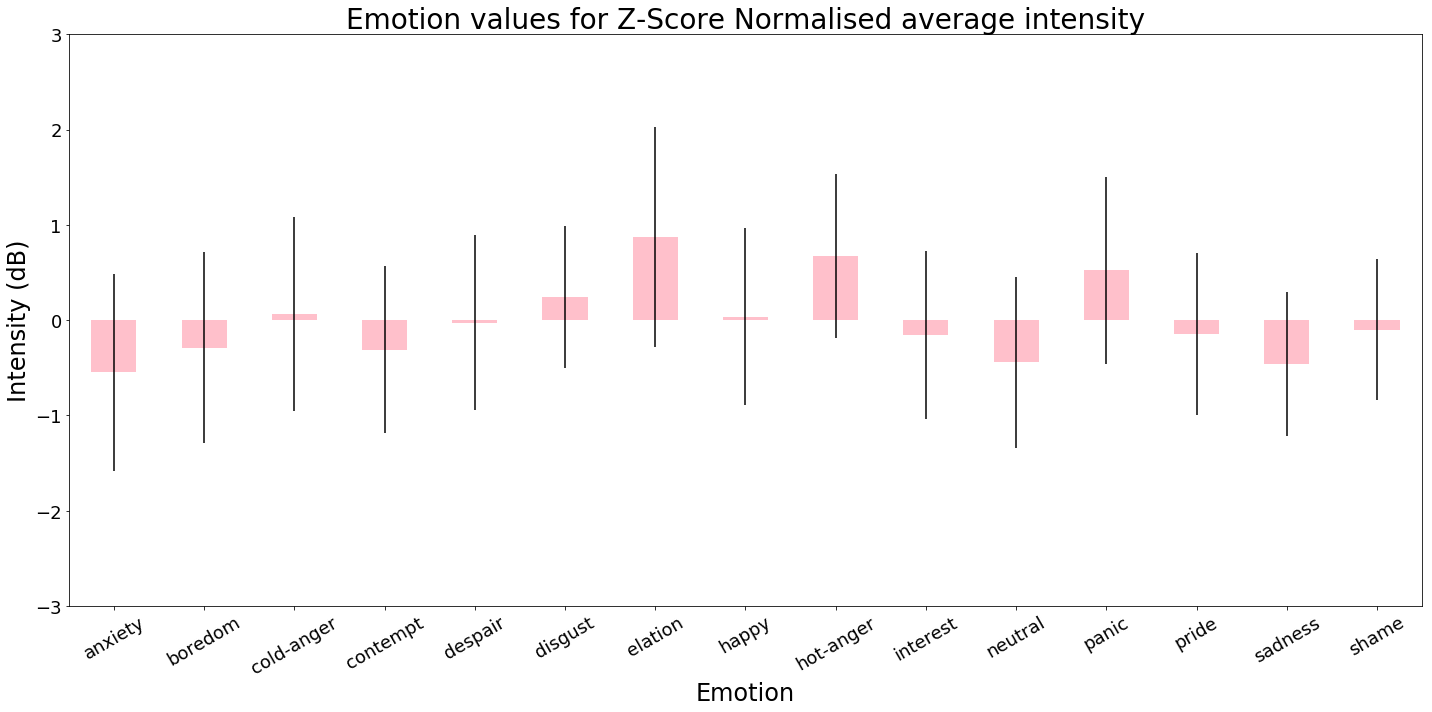

In [11]:
# z-score nomarlisation by speaker

# plotting the mean and the standard deviation
zfeat = feat
zmean = zfeat.groupby("speaker").mean()
zstd = zfeat.groupby("speaker").std()
for i, row in zfeat.iterrows():
    zfeat.at[i, 'minimum_pitch'] = (row['minimum_pitch'] - zmean['minimum_pitch'][row['speaker']])/(zstd['minimum_pitch'][row['speaker']])
    zfeat.at[i, 'maximum_pitch'] = (row['maximum_pitch'] - zmean['maximum_pitch'][row['speaker']])/(zstd['maximum_pitch'][row['speaker']])
    zfeat.at[i, 'average_pitch'] = (row['average_pitch'] - zmean['average_pitch'][row['speaker']])/(zstd['average_pitch'][row['speaker']])
    zfeat.at[i, 'minimum_intensity']  = (row['minimum_intensity'] - zmean['minimum_intensity'][row['speaker']])/(zstd['minimum_intensity'][row['speaker']])
    zfeat.at[i, 'maximum_intensity'] = (row['maximum_intensity'] - zmean['maximum_intensity'][row['speaker']])/(zstd['maximum_intensity'][row['speaker']])
    zfeat.at[i, 'average_intensity'] = (row['average_intensity'] - zmean['average_intensity'][row['speaker']])/(zstd['average_intensity'][row['speaker']])
    

mean = zfeat.groupby("emotion").mean()
std = zfeat.groupby("emotion").std()

cname = list(mean.columns)
print(cname)
for x in range(6):
    f = cname[x]
    plt.figure()
    plot = mean[f].plot(figsize=(20,10) , kind="bar", rot=30,
                        color='pink',
                        fontsize=18 ,yerr=std[f])
    
    
    # title
    plot.set_title("Emotion values for Z-Score Normalised "+ f.split('_')[0] + ' ' + f.split('_')[1], fontsize= 28)
    # x label
    plot.set_xlabel("Emotion", fontsize=24)
    # y label
    if x < 3:
        plot.set_ylabel("Pitch (Hz)", fontsize=24)
        plot.set_ylim(-3,3)
    else:
        plot.set_ylabel("Intensity (dB)", fontsize=24)
        plot.set_ylim(-3,3)
        
    # save the figure
    plt.tight_layout()
    plt.savefig('./Images/' + "zscore" + f + ".jpg")